###  MicroGrad demo

In [70]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

%matplotlib inline

In [71]:
np.random.seed(1337)
random.seed(1337)

In [72]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n._name, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [73]:
# Загрузка данных MNIST
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

# Преобразование данных в формат float32
X_train = X_train.astype('float64') / 255.0 * 2 - 1
X_test = X_test.astype('float64') / 255.0 * 2 - 1

# Изменение формы данных
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

# One-hot кодирование меток
# y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=10)
# y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes=10)

# y_train_oh

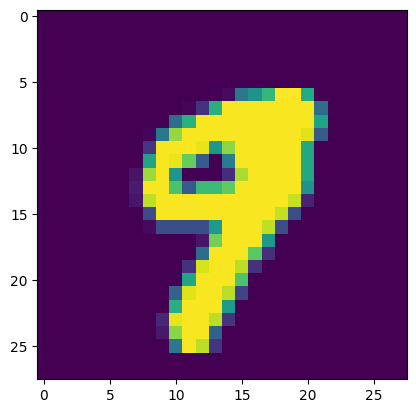

In [74]:
def draw_some(numbers):
    number = numbers[random.randint(0, numbers.shape[0] - 1)]
    plt.imshow(number.reshape([28, 28]))

draw_some(X_train)

In [75]:
from collections import defaultdict

ALL_POSITIVE_CLASSES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def oh_encode(classes):
    NEG = -1.0
    POS = 1.0

    noise = np.array([NEG] * len(classes))

    oh_enc = defaultdict(lambda: noise)
    oh_dec = defaultdict(lambda: None)

    for i, cls in enumerate(classes):
        cls_vec = np.array([NEG] * len(classes))
        cls_vec[i] = POS
        oh_enc[cls] = cls_vec
        oh_dec[tuple(cls_vec)] = cls

    def oh_decoder(values):
        # pick the closest vector (is round() OK for that?)
        encoded = tuple(np.array([v.data for v in values]).round())
        return oh_dec[encoded]

    def oh_encoder(Y):
        return np.array([oh_enc[cls] for cls in Y])

    return oh_encoder, oh_decoder

# OH_ENCODER, OH_DECODER = oh_encode(POSITIVE_CLASSES)

In [76]:
def get_batch(X, Y_oh, batch_size):
    ri = np.random.permutation(X.shape[0])[:batch_size]
    X, Y_oh = X[ri], Y_oh[ri]
    return X, Y_oh


def arr2vals(array, name=''):
    return [[Value(el, _name=name) for el in row] for row in array]


def batch2vals(batch):
    return tuple(map(arr2vals, batch))

In [77]:
def calc_accuracy(scores, ground_truths, oh_decoder):
    matches = 0
    for score, ground_truths in zip(scores, ground_truths):
        matches += oh_decoder(score) == oh_decoder(ground_truths)
    return matches / len(scores)


def one_loss(score, ground_truth):
    return sum((s - gt)**2 for s, gt in zip(score, ground_truth))


def calc_loss(scores, Y_oh):
    return sum(one_loss(xs, ys) for xs, ys in zip(scores, Y_oh))


def feed_forward(model, X):
    return list(map(model, X))


def evaluate(model, X, Y_oh, oh_decoder):
    input = arr2vals(X, 'input')
    scores = feed_forward(model, input)
    expected = arr2vals(Y_oh, 'expected')
    return calc_loss(scores, expected), calc_accuracy(scores, expected, oh_decoder)

# save/load

In [78]:
POSITIVE_NEURONS = 'mnist_parameters_10x785_positives.npy'


def save_neurons(file, neurons):
    weights = np.array([[p.data for p in n.parameters()] for n in neurons])
    np.save(file, weights)


def load_neurons(file):
    weights = np.load(file)
    neurons = [Neuron(nin=weights.shape[1] - 1, act='xspace') for _ in range(weights.shape[0])]
    for Wi in range(len(neurons)):
        for p, w in zip(neurons[Wi].parameters(), weights[Wi]):
            p.data = w
            p._lr = 0.0
    return neurons

In [79]:
def freeze_layers(model, lids: list):
    for idx in lids:
        for p in model.layers[idx].parameters():
            p._lr = 0.0


def norm_layers(model):
    for layer in model.layers:
        for neuron in layer.neurons:
            norm = sum(abs(p.data) for p in neuron.parameters())
            for p in neuron.parameters():
                p.data /= norm

In [80]:
# select positives
def select(X, Y, selector):
    idx = np.where(np.isin(Y, selector))[0]
    return X[idx], Y[idx]

def select_batch(X, Y, selector, batch_size):
    idx = np.where(np.isin(Y, selector))[0]
    return get_batch(X[idx], Y[idx], batch_size)

def draw_neuron(model, idx):
    w = np.array([p.data for p in model.layers[0].neurons[idx].parameters()][:-1])
    w = w.reshape([-1, w.shape[0]])
    draw_some(w)

In [81]:
def fit(model, X, Y_oh, oh_decoder, iterations, q=0.75, esat=1e-9):
    total_loss, acc = evaluate(model, X, Y_oh, oh_decoder)
    print(f"start: loss {total_loss.data}, accuracy {acc*100}%")

    for k in range(iterations):
        if total_loss.data == 0:
            print(f"step {k}: loss {total_loss.data}, accuracy {acc*100}%")
            return total_loss.data, acc

        model.learn_from(total_loss, q)
        model.norm()

        total_loss, acc = evaluate(model, X, Y_oh, oh_decoder)
        print(f"step {k}: loss {total_loss.data}, accuracy {acc*100}%")

        if total_loss.data <= esat:
            print(f"Early STOP!")
            break

    return total_loss.data, acc



def get_model_for(classes, batch, iterations, model=None, esat=1e-9):
    X, Y = batch

    oh_encoder, oh_decoder = oh_encode(classes)
    n = len(classes)

    Y_oh = oh_encoder(Y)

    # initialize a model
    if model is None:
        model = MLP(
            784,
            [
                (len(classes), 'xspace')
            ],
            lr=1.0
        )

    # frozen_positives = [n for c, n in enumerate(load_neurons(POSITIVE_NEURONS)) if c in classes]
    # model.layers[0].neurons = frozen_positives + model.layers[0].neurons[:-len(frozen_positives)]

    total_loss, acc = fit(model, X, Y_oh, oh_decoder, iterations, esat=esat)

    return model, total_loss, acc

In [82]:
SELECTED_CLASSES = [0, 1]
ITERATIONS = 10
BATCH_SIZE = 100
BATCH = X, Y = select_batch(X_train, Y_train, SELECTED_CLASSES, BATCH_SIZE)

model, total_loss, accuracy = get_model_for(SELECTED_CLASSES, BATCH, ITERATIONS)

start: loss 480.0, accuracy 21.0%
step 0: loss 408.0, accuracy 49.0%
step 1: loss 408.0, accuracy 49.0%
step 2: loss 408.0, accuracy 49.0%
step 3: loss 408.0, accuracy 49.0%
step 4: loss 408.0, accuracy 49.0%
step 5: loss 408.0, accuracy 49.0%
step 6: loss 408.0, accuracy 49.0%
step 7: loss 408.0, accuracy 49.0%
step 8: loss 408.0, accuracy 49.0%
step 9: loss 408.0, accuracy 49.0%


# DEBUG

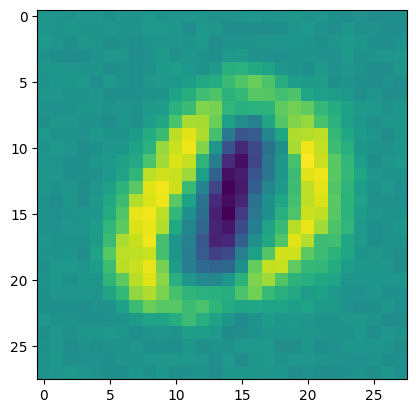

In [99]:
draw_neuron(model, 0)

start: loss 3.2047474274603605e-31, accuracy 100.0%
step 0: loss 3.4512664603419266e-31, accuracy 100.0%
step 1: loss 3.4512664603419266e-31, accuracy 100.0%
step 2: loss 3.2047474274603605e-31, accuracy 100.0%
step 3: loss 3.4512664603419266e-31, accuracy 100.0%
step 4: loss 3.2047474274603605e-31, accuracy 100.0%
step 5: loss 4.190823558986625e-31, accuracy 100.0%
step 6: loss 3.4512664603419266e-31, accuracy 100.0%
step 7: loss 2.341930812374879e-31, accuracy 100.0%
step 8: loss 2.711709361697228e-31, accuracy 100.0%
step 9: loss 2.0954117794933126e-31, accuracy 100.0%
step 10: loss 2.341930812374879e-31, accuracy 100.0%
step 11: loss 2.2186712959340957e-31, accuracy 100.0%
step 12: loss 4.807121141190541e-31, accuracy 100.0%
step 13: loss 3.2047474274603605e-31, accuracy 100.0%
step 14: loss 3.4512664603419266e-31, accuracy 100.0%
step 15: loss 4.930380657631324e-31, accuracy 100.0%
step 16: loss 3.3280069439011436e-31, accuracy 100.0%
step 17: loss 3.0814879110195774e-31, accuracy

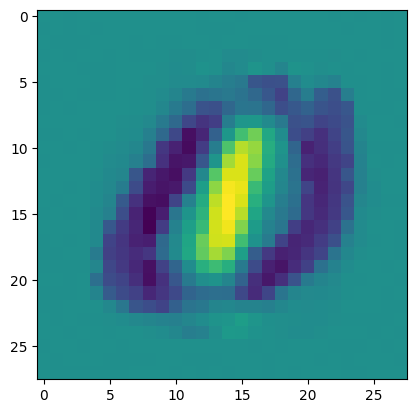

In [98]:
model, total_loss, accuracy = get_model_for(SELECTED_CLASSES, BATCH, 100, model, esat=0.0)
draw_neuron(model, -1)

In [97]:
import pandas as pd

numbers = [p.data for p in model.layers[0].neurons[0].parameters()]
numbers.sort()

pd.DataFrame(numbers).describe()

,0
count,785.000000
mean,0.157399
std,1.000638
min,-3.548872
25%,-0.236754
50%,-0.105589
75%,0.406190
max,3.009893
